In [1]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
import numpy as np
from lonboard import viz
import h3

import pandas as pd

from palettable.cartocolors.diverging import Geyser_7_r
from shapely.geometry import Polygon
from sidecar import Sidecar
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_continuous_cmap

In [ ]:
# Load country boundaries (Canada)
gdf = gpd.read_file('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
canada_gdf = gdf[gdf['NAME'] == 'Canada']

In [10]:
gdf = gpd.read_file('data/lpr_000b16a_e/lpr_000b16a_e.shp')
quebec_gdf = gdf[gdf['PRENAME'] == 'Quebec']

# apply crs to the geodataframe
quebec_gdf = quebec_gdf.to_crs(epsg=4326)

In [7]:
def plot_raster_data(raster_data, bounds):
    fig, ax = plt.subplots(figsize=(10, 10))
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
    im = ax.imshow(
        raster_data, 
        cmap='viridis', 
        extent=extent,
    )
    ax.set_title('Canada Climate Data')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Add a colorbar to show the temperature gradient
    cbar = plt.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Temperature')

    plt.show()

def open_tif(file_name):
    with rasterio.open(file_name) as src:
        raster_data = src.read(1, masked=True)  # read the first band
        affine = src.transform
        raster_data = np.where(raster_data == raster_data.min(), np.nan, raster_data)
        bounds = src.bounds
    return raster_data, bounds

def visualize_tif(file_name):
    raster_data, bounds = open_tif(file_name)
    plot_raster_data(raster_data, bounds)

In [8]:
raster_data, bounds = open_tif('data\worldClim\clipped_wc2.1_30s_bio_1.tif')
plot_raster_data(raster_data, bounds)

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_35912/1589462537.py:1: SyntaxWarning: invalid escape sequence '\w'
  raster_data, bounds = open_tif('data\worldClim\clipped_wc2.1_30s_bio_1.tif')
/tmp/ipykernel_35912/1589462537.py:1: SyntaxWarning: invalid escape sequence '\w'
  raster_data, bounds = open_tif('data\worldClim\clipped_wc2.1_30s_bio_1.tif')


RasterioIOError: data\worldClim\clipped_wc2.1_30s_bio_1.tif: No such file or directory

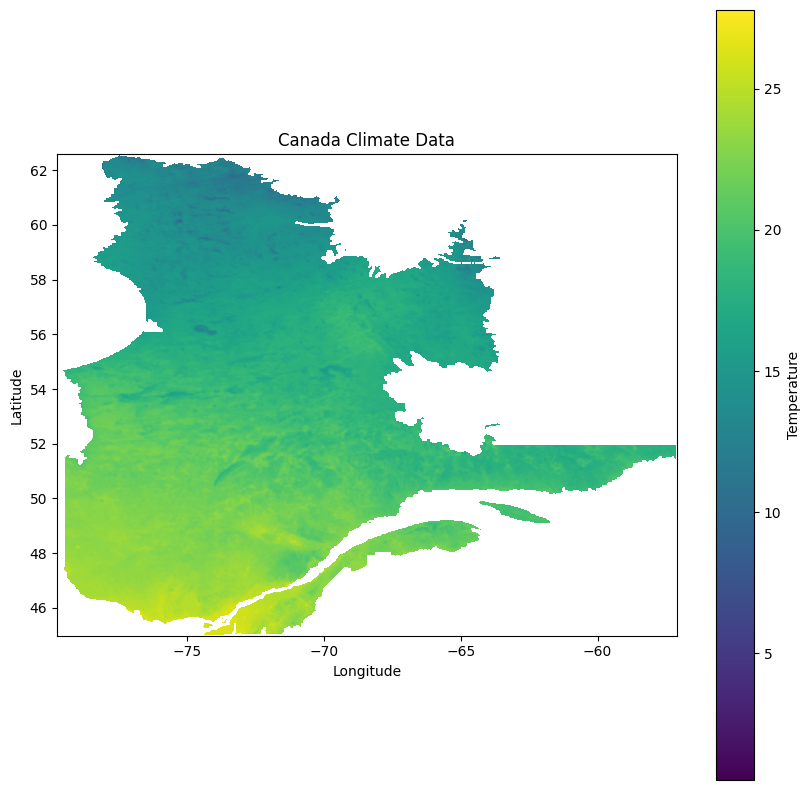

In [16]:
visualize_tif("data\worldClim\clipped_wc2.1_30s_bio_5.tif")

## Create geo_df of species

In [3]:
from shapely.geometry import Point

def pd_to_gpd(df):
    # Create a GeoDataFrame from the DataFrame
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)

    if geo_df.crs is None:
        geo_df.set_crs(epsg=4326, inplace=True)
    return geo_df


def geo_to_h3(row):
  H3_res = 5
  return h3.latlng_to_cell(lat=row.latitude,lng=row.longitude, res=H3_res)

In [95]:
import pandas as pd

import pyarrow.parquet as pq

parquet_file = pq.ParquetFile('data/atlas_public_2024-07-16.parquet')
batches = []
geo_df = gpd.GeoDataFrame(data=None, columns=['geometry', 'h3_cell', 'count', 'species'])

for i, batch in enumerate(parquet_file.iter_batches(batch_size=10000)):
    print(f'Processing batch {i}')
    # if i >= 70:
    #     break
    raw_batch = pd_to_gpd(batch.to_pandas())
    raw_batch['species'] = raw_batch['valid_scientific_name']
    raw_batch = raw_batch[['species', 'latitude', 'longitude']]

    raw_batch['h3_cell'] = raw_batch.apply(geo_to_h3, axis=1)

    # # Calculate the species count of unique h3_cells and species
    # h3_distribution = raw_batch.groupby(['h3_cell', 'species']).size()
    # h3_distribution = h3_distribution.reset_index(name='count')


    # raw_batch = raw_batch.merge(h3_distribution, on=['h3_cell', 'species'], how='left')
    # raw_batch = raw_batch.drop_duplicates(subset=['h3_cell', 'species'])
    # #if a row exist in geo_df with the same h3_cell and species, update the count, otherwise append the row
    # for index, row in raw_batch.iterrows():
    #     condition = (geo_df['h3_cell'] == row['h3_cell']) & (geo_df['species'] == row['species'])
    #     if condition.any():
    #         geo_df.loc[condition, 'count'] += row['count']
    #     else:
    #         geo_df = pd.concat([geo_df, gpd.GeoDataFrame([row], columns=geo_df.columns)], ignore_index=False)


    # Group by h3_cell and aggregate the species count and species list
    grouped = raw_batch.groupby('h3_cell').agg({
        'species': ['nunique', list]  # Count unique species and aggregate species into a list
    }).reset_index()


    # Flatten the MultiIndex columns
    grouped.columns = ['h3_cell', 'species_count', 'species_list']

    print(grouped['species_count'].sum())

    # Merge the geometry back into the grouped DataFrame

    grouped = grouped.merge(geo_df[['h3_cell']], on='h3_cell', how='left')

    # Merge the grouped DataFrame back into the geo_df.
    geo_df = pd.concat([geo_df, grouped], ignore_index=True)
    # Group by h3_cell, append species list, and sum species count

    geo_df = geo_df.groupby('h3_cell').agg({
        'species_list': lambda x: list(set([item for sublist in x for item in sublist])), 
    }).reset_index()

    geo_df['species_count'] = geo_df['species_list'].apply(len)



Processing batch 0
3001
Processing batch 1
5558
Processing batch 2
4768
Processing batch 3
4666
Processing batch 4
3654
Processing batch 5
1912
Processing batch 6
1384
Processing batch 7
2137
Processing batch 8
3027
Processing batch 9
3521
Processing batch 10
6141
Processing batch 11
6601
Processing batch 12
5074
Processing batch 13
4979
Processing batch 14
5015
Processing batch 15
4959
Processing batch 16
4993
Processing batch 17
4993
Processing batch 18
4961
Processing batch 19
5045
Processing batch 20
5014
Processing batch 21
4979
Processing batch 22
5033
Processing batch 23
4922
Processing batch 24
4980
Processing batch 25
4996
Processing batch 26
5010
Processing batch 27
4939
Processing batch 28
4972
Processing batch 29
4949
Processing batch 30
4965
Processing batch 31
5002
Processing batch 32
4996
Processing batch 33
4934
Processing batch 34
4971
Processing batch 35
5018
Processing batch 36
5017
Processing batch 37
5140
Processing batch 38
5033
Processing batch 39
5062
Processing

In [ ]:
## ONly useful when using the old way of creating the geo_df

# # Group by h3_cell and aggregate the species count and species list
# grouped = geo_df.groupby('h3_cell').agg({
#     'species': ['nunique', list]  # Count unique species and aggregate species into a list
# }).reset_index()

# # Flatten the MultiIndex columns
# grouped.columns = ['h3_cell', 'species_count', 'species_list']

# # Merge the geometry back into the grouped DataFrame
# grouped = grouped.merge(geo_df[['h3_cell', 'geometry']].drop_duplicates('h3_cell'), on='h3_cell', how='left')

# # Convert to a GeoDataFrame
# unique_h3_cells = gpd.GeoDataFrame(grouped, geometry='geometry')

# # Display the resulting GeoDataFrame
# unique_h3_cells

In [ ]:
geo_df.to_file("geo_df.gpkg", layer='geo_df', driver="GPKG")

## Load species geo_df

In [32]:
geo_df = gpd.read_file("geo_df.gpkg", layer='geo_df')

In [33]:
def add_geometry(row):
  points = h3.cell_to_boundary(row['h3_cell'])
  flipped = tuple(coord[::-1] for coord in points)
  return Polygon(flipped)




In [34]:
geo_df['geometry'] = (geo_df.apply(add_geometry,axis=1))
geo_df = gpd.GeoDataFrame(geo_df, geometry='geometry')

In [23]:
geo_df.boundary

0       LINESTRING (-77.22227 60.52997, -77.38542 60.4...
1       LINESTRING (-77.02916 60.39057, -77.19194 60.3...
2       LINESTRING (-77.56424 60.51653, -77.72674 60.4...
3       LINESTRING (-77.36975 60.37763, -77.53189 60.3...
4       LINESTRING (-76.88002 60.54253, -77.04381 60.4...
                              ...                        
4945    LINESTRING (-78.27573 50.74209, -78.3994 50.68...
4946    LINESTRING (-78.12416 50.60809, -78.24764 50.5...
4947    LINESTRING (-77.9027 50.90551, -78.02738 50.85...
4948    LINESTRING (-77.75174 50.7709, -77.87621 50.71...
4949    LINESTRING (-78.16559 50.89105, -78.28987 50.8...
Length: 4950, dtype: geometry

In [8]:
sidecar = Sidecar()

layer = PolygonLayer.from_geopandas(geo_df)
m = Map(layer, _height=800)

display(m)

/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:33: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


Map(custom_attribution='', layers=(PolygonLayer(table=arro3.core.Table
-----------
h3_cell: Utf8
species_list:…

In [9]:
species_counts = np.log1p(geo_df['species_count'])

upper_bound = species_counts.min()
lower_bound = species_counts.max()
species_counts = (species_counts - lower_bound) / (upper_bound - lower_bound)

layer.get_fill_color = apply_continuous_cmap(
    species_counts, Geyser_7_r, alpha=0.7
)

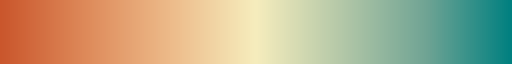

In [39]:
Geyser_7_r.mpl_colormap

In [3]:
from h3 import LatLngPoly, LatLngMultiPoly

In [12]:
# Function to convert MULTIPOLYGON to LatLngMultiPoly
def multipolygon_to_latlngmultipoly(multipolygon):
    latlngmultipoly = []
    for polygon in multipolygon.geoms:  # Iterate over individual polygons
        latlngpoly = []
        for coord in polygon.exterior.coords:
            latlngpoly.append([coord[1], coord[0]])  # Convert to [lat, lng]
        latlngmultipoly.append(latlngpoly)
    return latlngmultipoly

# Convert the quebec_gdf to LatLngMultiPoly
quebec_latlngmultipoly = multipolygon_to_latlngmultipoly(quebec_gdf.geometry.values[0])


In [13]:
quebec_latlngmultipoly[2]

[[49.65531685492711, -62.696051176423154],
 [49.65260728525221, -62.69387588536768],
 [49.646617570195396, -62.69130301196838],
 [49.64369559794549, -62.68825704655497],
 [49.64252230687632, -62.68576888351041],
 [49.64301229227631, -62.683198823165405],
 [49.64277212961608, -62.67387784071806],
 [49.64216056328851, -62.67155403912383],
 [49.640420433792876, -62.66884953002834],
 [49.63985541458338, -62.668183003376335],
 [49.638730007264584, -62.66792539486752],
 [49.637444150415085, -62.66710183897852],
 [49.63603802554917, -62.66656646265508],
 [49.63413614143454, -62.66634293131671],
 [49.632773838258515, -62.66541389246601],
 [49.63180604197864, -62.66379150643094],
 [49.63134559678367, -62.66128539425769],
 [49.63044634810245, -62.65826163337562],
 [49.629089741957415, -62.65299396492327],
 [49.627832592012936, -62.650542729388576],
 [49.6261969117056, -62.64879298338857],
 [49.62338440095304, -62.64728566322847],
 [49.621099626975194, -62.644205667891654],
 [49.620216208710865, 

In [28]:
# Convert each list of coordinates in quebec_latlngmultipoly to a LatLngPoly
quebec_polys = [LatLngPoly(coords) for coords in quebec_latlngmultipoly[3:6]]

# Combine the LatLngPoly objects into a LatLngMultiPoly
quebec_latlngmultipoly_obj = LatLngMultiPoly(*quebec_polys)

# Display the LatLngMultiPoly object
print(quebec_latlngmultipoly_obj)

<LatLngMultiPoly: [4829], [2633], [2446]>


In [29]:


# Ensure quebec_latlngmultipoly_obj is correctly defined
quebec_polys = [LatLngPoly(coords) for coords in quebec_latlngmultipoly]
quebec_latlngmultipoly_obj = LatLngMultiPoly(*quebec_polys)

# Convert Quebec's LatLngMultiPoly to H3 cells
h3_cells = h3.h3shape_to_cells(quebec_latlngmultipoly_obj, 5)

h3_cells = pd.DataFrame(h3_cells, columns=['h3_cell'])

h3_cells['geometry'] = h3_cells.apply(add_geometry, axis=1)

h3_cells = gpd.GeoDataFrame(h3_cells, geometry='geometry')

In [30]:
sidecar = Sidecar()

layer = PolygonLayer.from_geopandas(h3_cells)
m = Map(layer, _height=800)

display(m)

/home/alexis/Documents/projets/species-dist/.venv/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:33: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


Map(custom_attribution='', layers=(PolygonLayer(table=arro3.core.Table
-----------
h3_cell: Utf8
geometry: Lis…

In [35]:
merged_df = geo_df.merge(h3_cells, on='h3_cell', how='inner')

In [37]:
h3_cells

,h3_cell,geometry
0,850e49bbfffffff,"POLYGON ((-67.39892 49.44573, -67.53013 49.403..."
1,850e53d7fffffff,"POLYGON ((-75.21428 53.88858, -75.35236 53.836..."
2,850e722bfffffff,"POLYGON ((-72.53437 56.10579, -72.68432 56.056..."
3,850ecd27fffffff,"POLYGON ((-79.2796 49.68372, -79.39881 49.6283..."
4,852ba24ffffffff,"POLYGON ((-74.8324 48.48826, -74.95376 48.4379..."
...,...,...
5139,850f5ea7fffffff,"POLYGON ((-65.68334 59.15421, -65.85458 59.113..."
5140,850e4da3fffffff,"POLYGON ((-66.27529 50.24481, -66.40988 50.203..."
5141,852b3153fffffff,"POLYGON ((-64.15239 48.58477, -64.28306 48.546..."
5142,851b820bfffffff,"POLYGON ((-57.60902 51.50796, -57.75207 51.477..."
